<a href="https://colab.research.google.com/github/AhmedAdelDraz/images_anomaly_detection/blob/main/Image_Anomaly_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !wget -q https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip
# !unzip -q cell_images.zip
# !pip -q install torchsummary

In [ ]:
# import the needed libraries
import os
import glob
import cv2
import numpy as np
import random
from PIL import Image
from pathlib import Path
import tqdm
import scipy

import matplotlib.pyplot as plt
import seaborn as sns

import torch 
import torch.nn as nn
from torch.utils.data import DataLoader

import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.models import vgg16
from skimage.feature.peak import peak_local_max

from torchsummary import summary

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # define the device you will train the model on

# **Create Dataset**

In [ ]:
## fetch all the dataset images' paths 
data_path = "/content/cell_images/"
total_images = glob.glob(data_path+"/*/*.png",recursive=True)
random.shuffle(total_images) #shuffling here is very important here to avoid biased learning

In [ ]:
## split the dataset to train and test data 
train_paths = total_images[:int(0.8*len(total_images))]
test_paths = total_images[int(0.8*len(total_images)):]
print(f"train_paths:\t{len(train_paths)}\n"
      f"test_paths:\t{len(test_paths)}")

train_paths:	22046
test_paths:	5512


In [ ]:
class Data(torch.utils.data.Dataset):
  def __init__(self,data,transform=None):
    self.data = data
    self.transform = transform

  def __getitem__(self,idx):
    image_path = Path(self.data[idx])
    image = Image.open(image_path)

    if self.transform:
       image = self.transform(image)
    
    if image_path.parent.stem == "Parasitized":
      label = 1
    else:
      label = 0

    return image,label
  
  def __len__(self):
    return len(self.data)

In [ ]:
train_transforms = transforms.Compose([transforms.Resize((224,224)),
                                 transforms.ToTensor()])
test_transforms = transforms.Compose([transforms.Resize((224,224)),
                                 transforms.ToTensor()])

train_dataset = Data(train_paths,transform=train_transforms)
test_dataset  = Data(test_paths,transform=test_transforms) 

train_dataloader = DataLoader(train_dataset,batch_size=128,shuffle=True)
test_dataloader  = DataLoader(test_dataset ,batch_size=64,shuffle=True) 

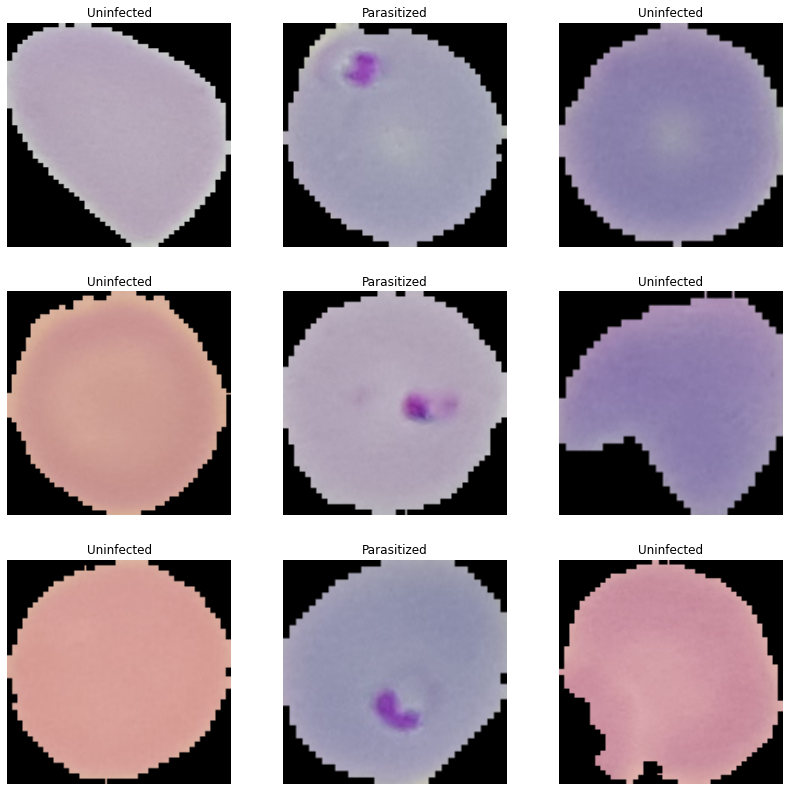

In [ ]:
## Visualize some randomly selected samples of dataset
classes = {0:"Uninfected",1:"Parasitized"}
images,labels = next(iter(train_dataloader))

fig,axes = plt.subplots(3,3,figsize=(14,14))
for i in range(3):
  for j in range(3):
    index = np.random.randint(len(images),size=1)
    image = torch.squeeze(images[index]).numpy()
    image = np.moveaxis(image,0,2) # pytorch images have the channel first so we need to move the channel to last axis to be able to plot it.
    plt.sca(axes[i,j]) 
    plt.imshow(image)
    plt.title(f"{classes[labels[index].item()]}")
    plt.axis("off");

# **Building the model** 

In [ ]:
model = vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [ ]:
## based on model architecture we will freeze all conv layer except the last convs
for i ,layer in enumerate(model.features):
  if i <= 24:
    for param in layer.parameters():
      param.requires_grad = False

model.avgpool = nn.AdaptiveAvgPool2d(1) # adding global average pooling layer   
model.classifier = nn.Linear(512,2) # adding the classifier layer
model.to(device);

In [ ]:
summary(model,input_size=(3,224,224),device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [ ]:
criterion = nn.CrossEntropyLoss() # loss function 
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3) #optimizer

# **Model Training**

In [ ]:
def batch_train(data,model,optimizer,criterion):
  """
  This function trains the model on single batch.
  Args: - data: batch contains the images and its corresponding labels.
        - model: the model itself which we need to train.
        - optimizer: the optimizer of the training process.
        - criterion: the loss function.
  Returns:
        - the resultant of loss function.
        - the model acuraccy on that batch.
  """
  optimizer.zero_grad()
  images, labels = data
  images = images.to(device)
  labels = labels.to(device)

  logits = model(images)

  loss = criterion(logits,labels)
  loss.backward()
  optimizer.step()

  preds = logits.argmax(axis=1)
  accuracy = (preds == labels).float().mean()
  return loss.item(),accuracy.item()

In [ ]:
def batch_eval(data,model,criterion):
  """
  This function evaluates the model on single batch.
  Args: - data: batch contains the images and its corresponding labels.
        - model: the model itself which we need to evaluate.
        - criterion: the loss function.
  Returns:
      - the resultant of loss function.
      - the model acuraccy on that batch.
  """
  model.eval()
  images,labels = data
  images = images.to(device)
  labels = labels.to(device)
  
  logits = model(images)
  loss = criterion(logits,labels)

  preds = logits.argmax(axis=1)
  accuracy = (preds == labels).float().mean()
  return loss.item(),accuracy.item()

In [ ]:
# Training process
epochs = 3 

for epoch in range(epochs):
  train_epoch_loss = []; val_epoch_loss= []
  train_epoch_acc =  []; val_epoch_acc = []
  
  # training process
  for data in tqdm.tqdm(train_dataloader):
    loss,acc = batch_train(data,model,optimizer,criterion)
    train_epoch_loss.append(loss)
    train_epoch_acc.append(acc)
  
  # evaluation process
  for data in tqdm.tqdm(test_dataloader):
    loss,acc = batch_eval(data,model,criterion)
    val_epoch_loss.append(loss)
    val_epoch_acc.append(acc)

  # printting the model result for each epoch. 
  print(f"Epoch: {epoch+1}/{epochs}..\t"
        f"Loss: {sum(train_epoch_loss)/len(train_epoch_loss):.3f}..\t"
        f"Accuracy: {sum(train_epoch_acc)/len(train_epoch_acc):.3f}..\t"
        f"Test Loss: {sum(val_epoch_loss)/len(val_epoch_loss):.3f}..\t"
        f"Test Acuracy: {sum(val_epoch_acc)/len(val_epoch_acc):.3f}..\t")

100%|██████████| 87/87 [01:06<00:00,  1.31it/s]


Epoch: 1/3..	Loss: 0.207..	Accuracy: 0.920..	Test Loss: 0.140..	Test Acuracy: 0.957..	


100%|██████████| 87/87 [01:05<00:00,  1.32it/s]


Epoch: 2/3..	Loss: 0.137..	Accuracy: 0.956..	Test Loss: 0.134..	Test Acuracy: 0.958..	


100%|██████████| 87/87 [01:02<00:00,  1.38it/s]

Epoch: 3/3..	Loss: 0.121..	Accuracy: 0.958..	Test Loss: 0.121..	Test Acuracy: 0.959..	


# **Model Evaluation**

In [ ]:
def load_image(path):
  """
  This function used to preprocess the function to be able to be fed to model 
  Arg: - path: image path
  Return images in shape of [1,C,H,W] 
  """
  image = Image.open(path) # read the image
  image = test_transforms(image) # preprocess the image using the same transformation of test dataset
  image = torch.unsqueeze(image,0) # add the batch axis
  return image.to(device)

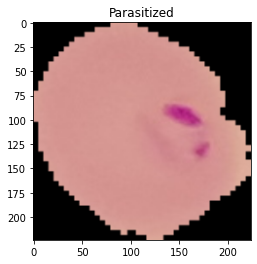

In [ ]:
# inspect the model predictions
model.eval()
image = load_image("/content/cell_images/Parasitized/C100P61ThinF_IMG_20150918_144348_cell_143.png")
prediction = model(image).argmax(axis=1)
image = torch.squeeze(image).cpu().numpy()
image = np.moveaxis(image,0,2)
plt.imshow(image)
plt.title(f"{classes[prediction.item()]}");

100%|██████████| 87/87 [01:08<00:00,  1.27it/s]


              precision    recall  f1-score   support

           0       0.97      0.95      0.96      2824
           1       0.95      0.97      0.96      2688

    accuracy                           0.96      5512
   macro avg       0.96      0.96      0.96      5512
weighted avg       0.96      0.96      0.96      5512



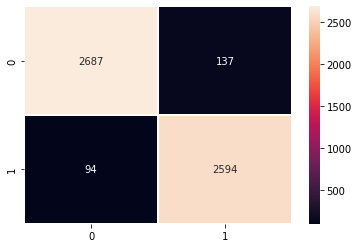

In [ ]:
#classification report
from sklearn.metrics import classification_report,confusion_matrix
y_pred = []
y_true = []
test_dataloader = DataLoader(test_dataset,batch_size = 64)

for images, labels in tqdm.tqdm(test_dataloader):
  images = images.to(device)
  preds = model(images).argmax(axis=1).cpu().numpy()
  y_pred.extend(preds)
  y_true.extend(labels.numpy())

print(classification_report(y_pred,y_true))
sns.heatmap(confusion_matrix(y_pred,y_true),annot=True,fmt="d",linewidths=.5);

# **Heat Map**

In [ ]:
def getHeatMap(image_path):
  model.eval()
  image = load_image(image_path)
  pred_class = model(image).argmax(axis=1)
  last_layer_weights = model.classifier.weight.cpu().detach().numpy()
  last_layer_weights_for_pred = last_layer_weights[pred_class,:]
  last_layer_weights_for_pred = last_layer_weights_for_pred.reshape((1,-1))
  
  last_conv_output = model.features[:-1](image).detach()
  last_conv_output = torch.squeeze(last_conv_output).cpu().numpy()

  h = int(image.shape[2]/last_conv_output.shape[1])
  w = int(image.shape[3]/last_conv_output.shape[2])
  upsampled_last_conv_output = scipy.ndimage.zoom(last_conv_output,(1,h,w),order=1)

  heat_map = np.dot(last_layer_weights_for_pred,upsampled_last_conv_output.reshape((512,image.shape[2]*image.shape[3]))).reshape(image.shape[2],image.shape[3])
  heat_map[image[:,0,:,:].squeeze().cpu().numpy() == 0 ] = 0
  return heat_map

0


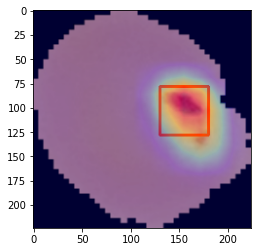

In [ ]:
image_path ="/content/cell_images/Parasitized/C100P61ThinF_IMG_20150918_144348_cell_143.png"

heat_map = getHeatMap(image_path)

peak_coords = peak_local_max(heat_map,num_peaks=5,threshold_rel=0.5,min_distance=10)
image = cv2.imread(image_path)
image = cv2.resize(image,(224,224))
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
for i in range(0,peak_coords.shape[0]):
  y = peak_coords[i,0]
  x = peak_coords[i,1]
  cv2.rectangle(image,(x-25,y-25),(x+25,y+25),(255,0,0),2)
plt.imshow(image)
plt.imshow(heat_map,cmap='jet',alpha=0.3);